In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# 日本語フォントの指定
mpl.rcParams['font.family'] = 'IPAexGothic' # ここにインストールしたフォント名を入れる

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from nyaggle.feature.category_encoder import TargetEncoder

from nyaggle.experiment import run_experiment

In [4]:
import copy
import warnings
from typing import Dict, Iterable, Optional, Union

import optuna.integration.lightgbm as optuna_lgb
import pandas as pd
import sklearn.utils.multiclass as multiclass
from sklearn.model_selection import BaseCrossValidator

from nyaggle.validation.split import check_cv
from nyaggle.experiment.hyperparameter_tuner import find_best_lgbm_parameter

In [23]:
train = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/train_feature_ver1.csv')
test = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/test_feature_ver1.csv')
era = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/era.csv')
sample_submission = pd.read_csv('yukiCup2023Autumn-atmaCup_dataset/yukiCup 2023 Autumn x atmaCup/sample_submission.csv')

In [6]:
#categorical変数抽出
cat_cols = [c for c in test.columns if train[c].dtype == np.object]

# numerical変数抽出
num_cols = [c for c in test.columns if train[c].dtype != np.object]

#目的変数抽出
target_col = 'is_kokuhou'

print(cat_cols)
print(num_cols)
print(target_col)

['棟名', '種別2', '国', '時代', '都道府県 ※美工品は「所有者住所（所在都道府県）」', '所在地', '保管施設の名称', '所有者名', '管理団体又は責任者']
['緯度', '経度', '開始', '終了', '緯度*経度', '終了-開始', 'label_棟名', 'label_種別2', 'label_国', 'label_時代', 'label_都道府県 ※美工品は「所有者住所（所在都道府県）」', 'label_所在地', 'label_保管施設の名称', 'label_所有者名', 'label_管理団体又は責任者', 'count_棟名', 'count_種別2', 'count_国', 'count_時代', 'count_都道府県 ※美工品は「所有者住所（所在都道府県）」', 'count_所在地', 'count_保管施設の名称', 'count_所有者名', 'count_管理団体又は責任者', '棟名_緯度_min', '棟名_緯度_max', '棟名_緯度_mean', '棟名_緯度_std', '棟名_経度_min', '棟名_経度_max', '棟名_経度_mean', '棟名_経度_std', '棟名_開始_min', '棟名_開始_max', '棟名_開始_mean', '棟名_開始_std', '棟名_終了_min', '棟名_終了_max', '棟名_終了_mean', '棟名_終了_std', '棟名_緯度*経度_min', '棟名_緯度*経度_max', '棟名_緯度*経度_mean', '棟名_緯度*経度_std', '棟名_終了-開始_min', '棟名_終了-開始_max', '棟名_終了-開始_mean', '棟名_終了-開始_std', '種別2_緯度_min', '種別2_緯度_max', '種別2_緯度_mean', '種別2_緯度_std', '種別2_経度_min', '種別2_経度_max', '種別2_経度_mean', '種別2_経度_std', '種別2_開始_min', '種別2_開始_max', '種別2_開始_mean', '種別2_開始_std', '種別2_終了_min', '種別2_終了_max', '種別2_終了_mean', '種別2_終了_std', '種

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [7]:
# target encoding

# kf = KFold(4)
# kf = KFold(4, groups=train.categorical)　#GroupKFold
kf = StratifiedKFold(5, shuffle=True, random_state=42531) #StratifiedKFold

# Target encoding with K-fold
# te = TargetEncoder(kf.split(train))
# te = TargetEncoder(kf.split(train)) #GroupKFold
te = TargetEncoder(kf.split(train, train[target_col])) #StratifiedKFold

# use fit/fit_transform to train data, then apply transform to test data
train.loc[:, cat_cols] = te.fit_transform(train[cat_cols], train[target_col])
test.loc[:, cat_cols] = te.transform(test[cat_cols])

In [11]:
train

,名称,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,...,管理団体又は責任者_終了_mean,管理団体又は責任者_終了_std,管理団体又は責任者_緯度*経度_min,管理団体又は責任者_緯度*経度_max,管理団体又は責任者_緯度*経度_mean,管理団体又は責任者_緯度*経度_std,管理団体又は責任者_終了-開始_min,管理団体又は責任者_終了-開始_max,管理団体又は責任者_終了-開始_mean,管理団体又は責任者_終了-開始_std
0,泉布観,0.086341,0.018656,0.050689,3.759398e-03,0.041263,0.074702,0.067246,0.092894,0.074234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,絹本著色准胝仏母像,0.087930,0.091445,0.081048,8.286252e-02,0.101900,0.082786,0.069094,0.154884,0.074074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,石上神宮拝殿,0.086341,0.136364,0.050689,3.719224e-01,0.153333,0.074702,0.067246,0.074702,0.074234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,剣〈銘真守（備前）／〉,0.087183,0.110973,0.081824,8.699809e-02,0.101848,0.080018,0.066914,0.144170,0.107958,...,1274.271605,173.612716,4638.384336,4640.494793,4639.024571,0.657243,30.0,391.0,222.54321,120.592501
4,旧新町紡績所,0.074702,0.000008,0.047437,8.493954e-13,0.028203,0.064105,0.066914,0.064105,0.073498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6705,平家物語,0.086635,0.116883,0.082075,8.474576e-03,0.111486,0.093146,0.100903,0.040971,0.073498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6706,因明論疏〈巻上中／〉,0.087930,0.117647,0.081048,1.099537e-01,0.109402,0.074282,0.083613,0.042912,0.074074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6707,石燈籠,0.086635,0.105853,0.082075,8.206107e-02,0.106897,0.074516,0.055906,0.052977,0.073498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6708,孔雀経音義〈真寂法親王撰／〉,0.087183,0.127832,0.081824,1.172914e-01,0.106599,0.080018,0.066914,0.160480,0.073498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
params = {
    'objective': "binary", # binary, multiclass, regression
    'metric': "binary_logloss", # mae, mse, auc, binary_logloss, multi_logloss, rmse, average_precision
    'learning_rate':0.05, #0.05
    'n_estimators': 10000,
    'max_depth': -1,
    'random_state' : 42531,
    #'num_leaves' : 100, #カーディナリティが高い場合は大きくする
    #'max_bin' : 500,
}

In [13]:
optuna_params = find_best_lgbm_parameter(base_param = params,
                         X=train.drop(['is_kokuhou', '名称'], axis=1), 
                         y=train['is_kokuhou'],
                         cv=StratifiedKFold(5, shuffle=True, random_state=42531),
                         time_budget=600,
                         type_of_target='auto'
                         ) 

[I 2023-11-25 03:27:12,966] A new study created in memory with name: no-name-90cb45a4-4e02-4e06-8474-f23bd8718fd0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[I 2023-11-25 03:27:13,698] Trial 0 finished with value: 0.22928414568988184 and parameters: {'featur

In [14]:
print(optuna_params)

{'objective': 'binary', 'metric': 'binary_logloss', 'learning_rate': 0.05, 'max_depth': -1, 'random_state': 42531, 'feature_pre_filter': False, 'verbosity': -1, 'lambda_l1': 0.0002736286090580672, 'lambda_l2': 0.0014099660582306847, 'num_leaves': 36, 'feature_fraction': 0.4, 'bagging_fraction': 0.6457369549922142, 'bagging_freq': 6, 'min_child_samples': 20, 'num_iterations': 10000, 'early_stopping_round': 100}


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.261728
[2]	valid_0's binary_logloss: 0.258115
[3]	valid_0's binary_logloss: 0.254906
[4]	valid_0's binary_logloss: 0.252307
[5]	valid_0's binary_logloss: 0.250502
[6]	valid_0's binary_logloss: 0.248555
[7]	valid_0's binary_logloss: 0.24619
[8]	valid_0's binary_logloss: 0.243803
[9]	valid_0's binary_logloss: 0.241937
[10]	valid_0's binary_logloss: 0.240466
[11]	valid_0's binary_logloss: 0.23842
[12]	valid_0's binary_logloss: 0.237259
[13]	valid_0's binary_logloss: 0.236164
[14]	valid_0's binary_logloss: 0.234643
[15]	valid_0's binary_logloss: 0.233511
[16]	valid_0's binary_logloss: 0.232575
[17]	valid_0's binary_logloss: 0.231893
[18]	valid_0's binary_logloss: 0.231092
[19]	valid_0's binary_logloss: 0.230128
[20]	valid_0's binary_logloss: 0.229462
[21]	valid_0's binary_logloss: 0.228912
[22]	valid_0's binary_logloss: 0.228481
[23]	valid_0's binary_logloss: 0.227357
[24]	valid_0's binary_logloss: 0.226657
[25]	valid_0's binary_logloss: 0.226811
[26]	valid_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'



[20]	valid_0's binary_logloss: 0.229672
[21]	valid_0's binary_logloss: 0.229197
[22]	valid_0's binary_logloss: 0.2287
[23]	valid_0's binary_logloss: 0.228776
[24]	valid_0's binary_logloss: 0.227833
[25]	valid_0's binary_logloss: 0.227888
[26]	valid_0's binary_logloss: 0.227542
[27]	valid_0's binary_logloss: 0.226848
[28]	valid_0's binary_logloss: 0.226475
[29]	valid_0's binary_logloss: 0.226503
[30]	valid_0's binary_logloss: 0.226669
[31]	valid_0's binary_logloss: 0.225993
[32]	valid_0's binary_logloss: 0.225823
[33]	valid_0's binary_logloss: 0.225429
[34]	valid_0's binary_logloss: 0.225092
[35]	valid_0's binary_logloss: 0.225031
[36]	valid_0's binary_logloss: 0.224149
[37]	valid_0's binary_logloss: 0.22409
[38]	valid_0's binary_logloss: 0.224102
[39]	valid_0's binary_logloss: 0.223715
[40]	valid_0's binary_logloss: 0.223379
[41]	valid_0's binary_logloss: 0.223071
[42]	valid_0's binary_logloss: 0.222936
[43]	valid_0's binary_logloss: 0.222827
[44]	valid_0's binary_logloss: 0.222561
[4

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[16]	valid_0's binary_logloss: 0.219898
[17]	valid_0's binary_logloss: 0.219144
[18]	valid_0's binary_logloss: 0.218298
[19]	valid_0's binary_logloss: 0.21764
[20]	valid_0's binary_logloss: 0.216482
[21]	valid_0's binary_logloss: 0.215818
[22]	valid_0's binary_logloss: 0.214839
[23]	valid_0's binary_logloss: 0.213932
[24]	valid_0's binary_logloss: 0.213073
[25]	valid_0's binary_logloss: 0.212512
[26]	valid_0's binary_logloss: 0.211868
[27]	valid_0's binary_logloss: 0.211665
[28]	valid_0's binary_logloss: 0.211413
[29]	valid_0's binary_logloss: 0.211557
[30]	valid_0's binary_logloss: 0.211627
[31]	valid_0's binary_logloss: 0.210557
[32]	valid_0's binary_logloss: 0.20964
[33]	valid_0's binary_logloss: 0.209274
[34]	valid_0's binary_logloss: 0.208818
[35]	valid_0's binary_logloss: 0.208547
[36]	valid_0's binary_logloss: 0.207657
[37]	valid_0's binary_logloss: 0.207314
[38]	valid_0's binary_logloss: 0.207046
[39]	valid_0's binary_logloss: 0.206645
[40]	valid_0's binary_logloss: 0.206116
[4

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[1]	valid_0's binary_logloss: 0.259221
[2]	valid_0's binary_logloss: 0.255477
[3]	valid_0's binary_logloss: 0.250136
[4]	valid_0's binary_logloss: 0.246771
[5]	valid_0's binary_logloss: 0.244689
[6]	valid_0's binary_logloss: 0.242334
[7]	valid_0's binary_logloss: 0.240594
[8]	valid_0's binary_logloss: 0.239112
[9]	valid_0's binary_logloss: 0.236927
[10]	valid_0's binary_logloss: 0.235141
[11]	valid_0's binary_logloss: 0.233808
[12]	valid_0's binary_logloss: 0.231906
[13]	valid_0's binary_logloss: 0.231077
[14]	valid_0's binary_logloss: 0.229958
[15]	valid_0's binary_logloss: 0.228134
[16]	valid_0's binary_logloss: 0.227056
[17]	valid_0's binary_logloss: 0.226065
[18]	valid_0's binary_logloss: 0.224807
[19]	valid_0's binary_logloss: 0.224477
[20]	valid_0's binary_logloss: 0.223654
[21]	valid_0's binary_logloss: 0.223058
[22]	valid_0's binary_logloss: 0.222446
[23]	valid_0's binary_logloss: 0.22161
[24]	valid_0's binary_logloss: 0.220899
[25]	valid_0's binary_logloss: 0.220523
[26]	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


[4]	valid_0's binary_logloss: 0.248242
[5]	valid_0's binary_logloss: 0.24505
[6]	valid_0's binary_logloss: 0.242218
[7]	valid_0's binary_logloss: 0.239502
[8]	valid_0's binary_logloss: 0.237818
[9]	valid_0's binary_logloss: 0.234935
[10]	valid_0's binary_logloss: 0.232614
[11]	valid_0's binary_logloss: 0.230388
[12]	valid_0's binary_logloss: 0.228472
[13]	valid_0's binary_logloss: 0.226456
[14]	valid_0's binary_logloss: 0.22492
[15]	valid_0's binary_logloss: 0.223505
[16]	valid_0's binary_logloss: 0.221752
[17]	valid_0's binary_logloss: 0.220274
[18]	valid_0's binary_logloss: 0.219081
[19]	valid_0's binary_logloss: 0.217627
[20]	valid_0's binary_logloss: 0.216173
[21]	valid_0's binary_logloss: 0.215438
[22]	valid_0's binary_logloss: 0.214045
[23]	valid_0's binary_logloss: 0.213885
[24]	valid_0's binary_logloss: 0.213355
[25]	valid_0's binary_logloss: 0.212886
[26]	valid_0's binary_logloss: 0.212481
[27]	valid_0's binary_logloss: 0.212658
[28]	valid_0's binary_logloss: 0.211858
[29]	val

/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.7/site-packages/nyaggle/util/plot_importance.py:57: UserWarning: Glyph 2

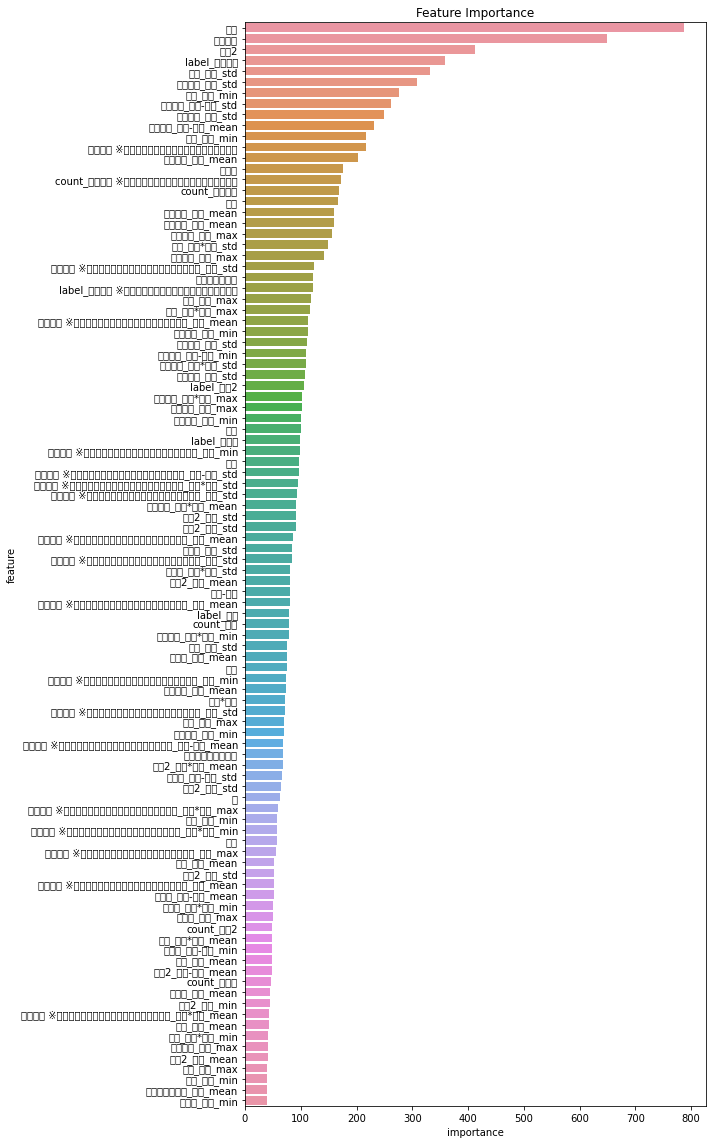

In [15]:
# 再度LightGBMで回す

result = run_experiment(optuna_params,
                        train[num_cols + cat_cols],
                        train[target_col],
                        test[num_cols + cat_cols],
                        cv=StratifiedKFold(5, shuffle=True, random_state=42531), #cv=4,
                        #groups=train.group
                        )

In [16]:
print(result.metrics) # Evalulation metrics for each fold

[0.819061996779388, 0.8029307568438003, 0.8495410628019323, 0.8191103059581321, 0.8451185166864792, 0.8252112299800464]


In [17]:
result.importance     # Feature importance for each fold

[                       feature  importance
 0                           緯度   88.289520
 1                           経度   62.729690
 2                           開始  173.593210
 3                           終了  106.372989
 4                        緯度*経度   86.241551
 ..                         ...         ...
 244  都道府県 ※美工品は「所有者住所（所在都道府県）」  208.560219
 245                        所在地  218.019808
 246                    保管施設の名称  136.096169
 247                       所有者名  725.456172
 248                  管理団体又は責任者   90.217170
 
 [249 rows x 2 columns],
                        feature  importance
 0                           緯度   71.962060
 1                           経度   85.899500
 2                           開始  159.160159
 3                           終了  120.026139
 4                        緯度*経度   81.772959
 ..                         ...         ...
 244  都道府県 ※美工品は「所有者住所（所在都道府県）」  191.598289
 245                        所在地  187.986960
 246                    保管施設の名称   57.038719
 247 

In [18]:
print(result.test_prediction)  # Test prediction in numpy array
print(result.oof_prediction)   # Out-of-fold prediction in numpy array

[0.01529058 0.2473737  0.29955036 ... 0.09977635 0.02522443 0.01409199]
[0.01474522 0.14593166 0.22391101 ... 0.04026878 0.3509301  0.0232702 ]


In [19]:
train[target_col].to_numpy()

array([0, 0, 1, ..., 0, 0, 0])

In [20]:
# データ全体のF1スコアを計算 & 閾値の最適化
from sklearn.metrics import f1_score

def find_optimal_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        y_pred = (y_scores > threshold).astype(int)
        score = f1_score(y_true, y_pred)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_threshold, best_score

# 例として使用するデータ（実際にはモデルからの予測値と実際のラベルを使用）
y_true = train[target_col].values
y_scores = result.oof_prediction

best_threshold, best_f1_score = find_optimal_threshold(y_true, y_scores)
print(f"Best threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

Best threshold: 0.18181818181818182
Best F1 Score: 0.37979094076655057


In [21]:
# 閾値を超える確率を持つ要素を1に、それ以外を0に変換
y_pred = (result.test_prediction > best_threshold).astype(int)
print(y_pred)
print(y_pred.shape)

[0 1 1 ... 0 0 0]
(10065,)


In [24]:
sample_submission['is_kokuhou'] = y_pred
sample_submission

,is_kokuhou
0,0
1,1
2,1
3,0
4,0
...,...
10060,0
10061,0
10062,0
10063,0


In [25]:
sample_submission["is_kokuhou"].value_counts()

0    9084
1     981
Name: is_kokuhou, dtype: int64

In [26]:
sample_submission.to_csv('optuna_ver1.csv', index=False)

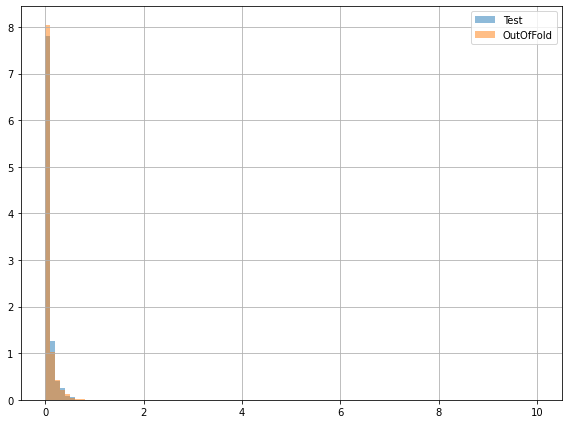

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = .02
bins = np.linspace(0, 10, 100)
ax.hist(result.test_prediction, bins=bins, density=True, alpha=.5, label="Test")
ax.hist(result.oof_prediction, bins=bins, density=True, alpha=.5, label="OutOfFold")
ax.grid()
ax.legend()
# ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()